In [1]:
import torch
import torch.nn as nn
from diffusers.schedulers import PNDMScheduler
from pathlib import Path
from diffusers import DiffusionPipeline
from util import onnx_export
from onnxruntime.quantization.quantize import quantize_dynamic
from onnxruntime.quantization import QuantType
import onnx 
from diffusers.utils import BaseOutput
import gc
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union
import onnxruntime as ort
import numpy as np
import os
from tqdm import tqdm

gc.collect()

onnx_root = '../onnx-models'

In [2]:
device = "cpu"
dtype = torch.float32

#### `ONNX` model loading
- Tokenizer & Text Encoder

In [3]:
sessTokenizer = ort.InferenceSession(f"{onnx_root}/tokenizer/tokenizer_quant.onnx")
# Print the input names and shapes
input_names = [input.name for input in sessTokenizer.get_inputs()]
output_names = [output.name for output in sessTokenizer.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

sessTextEncoder = ort.InferenceSession(f"{onnx_root}/TextEncoder/model_quant.onnx")
# Print the input names and shapes
input_names = [input.name for input in sessTextEncoder.get_inputs()]
output_names = [output.name for output in sessTextEncoder.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['input']
Output names: ['output']
Input names: ['prompt']
Output names: ['out_sample']


- Denoising (UNet + Schedulers)

In [4]:
sessUNetPre    = ort.InferenceSession('../onnx-models/UNet_pre/model-quant.onnx')
sessUNetPost   = ort.InferenceSession('../onnx-models/UNet_post/model-quant.onnx')

sessUNetDown    = ort.InferenceSession('../onnx-models/UNet-ver2/down_quant.onnx')
sessUNetMid     = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_mid_quant.onnx')
sessUNetUp0     = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_0/model_quant.onnx')
sessUNetUp1     = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_1/model_quant.onnx')
sessUNetUp2     = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_2/model_quant.onnx')
sessUNetUp3_0   = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_3_0/model_quant.onnx')
sessUNetUp3_1   = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_3_1/model_quant.onnx')
sessUNetUp3_2   = ort.InferenceSession('../onnx-models/UNet-ver2/unet2dconditionalmodel_up_3_2/model_quant.onnx')
sess_post       = ort.InferenceSession('../onnx-models/UNet-ver2/UNet_post_process/model.onnx')

In [5]:
schedulers = {
    i:ort.InferenceSession(f'{onnx_root}/Schedulers_quant/{i}') \
        for i \
        in os.listdir(f'{onnx_root}/Schedulers_quant/')
}

- Decoder

In [6]:
sessDecoder = ort.InferenceSession(f"{onnx_root}/Decoder/model_quant.onnx")
# Print the input names and shapes
input_names = [input.name for input in sessDecoder.get_inputs()]
output_names = [output.name for output in sessDecoder.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['latent_sample']
Output names: ['output']


---
#### 🍭 Function

In [7]:
sessUpList  = [sessUNetUp0, sessUNetUp1, sessUNetUp2]
up_3_list   = [sessUNetUp3_0, sessUNetUp3_1, sessUNetUp3_2]

def forward_UNet(x, t, text_embed):
    # x : [2 4 64 64]
    # t : [1]
    # text_embed : [2 77 768]
    
    #* Down
    outputs = sessUNetDown.run(None, {
        sessUNetDown.get_inputs()[0].name: x,
        sessUNetDown.get_inputs()[1].name: t,
        sessUNetDown.get_inputs()[2].name: text_embed
    })
    sample, emb, down_block_res_samples = outputs[0], outputs[1], outputs[2:]
    #* Mid
    outputs = sessUNetMid.run(None, {
        sessUNetMid.get_inputs()[0].name: sample,
        sessUNetMid.get_inputs()[1].name: emb,
        sessUNetMid.get_inputs()[2].name: text_embed
    })
    sample = outputs[0]
    #* Up
    for i in range(3):
        res_samples = down_block_res_samples[-3 :]
        down_block_res_samples = down_block_res_samples[: -3]
        if i == 0:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: res_samples[0],
                sessUpList[i].get_inputs()[3].name: res_samples[1],
                sessUpList[i].get_inputs()[4].name: res_samples[2],
            })
            sample = outputs[0]
            # print(sample.shape)
        else:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: text_embed,
                sessUpList[i].get_inputs()[3].name: res_samples[0],
                sessUpList[i].get_inputs()[4].name: res_samples[1],
                sessUpList[i].get_inputs()[5].name: res_samples[2],
            })
            sample = outputs[0]          
    for i in range(3):
        outputs = up_3_list[i].run(None, {
            up_3_list[i].get_inputs()[0].name: sample,
            up_3_list[i].get_inputs()[1].name: emb,
            up_3_list[i].get_inputs()[2].name: text_embed,
            up_3_list[i].get_inputs()[3].name: down_block_res_samples[-(i+1)],
        })
        sample = outputs[0]
    #* post-processing
    outputs = sess_post.run(
    None,{
        sess_post.get_inputs()[0].name: sample,
    })
    sample = outputs[0]
    return sample, x

In [8]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

---
#### 🍧 `ONNX` Test

In [9]:
# 1. 아스키 코드화
string = "a smile cat"
ascii_codes = np.array([ord(char) for char in string])
ascii_codes = torch.tensor(ascii_codes)     # [72 101 108 108 111]
arr = torch.full((1, 100), -1)
arr[0, :ascii_codes.size(0)] = ascii_codes

ort_inputs  = {'input': np.array(arr)}
ort_outputs = sessTokenizer.run(None, ort_inputs)
prompt = ort_outputs[0].astype(np.int32)
print(f"afer text tokenizer : {prompt.shape}")

ort_inputs  = {'prompt': prompt}
ort_outputs = sessTextEncoder.run(None, ort_inputs)
embed = ort_outputs[0]
print(f"afer text embedding : {embed.shape}")

afer text tokenizer : (1, 77)
afer text embedding : (2, 77, 768)


In [10]:
timesteps = [
    981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761,
    741, 721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501,
    481, 461, 441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241,
    221, 201, 181, 161, 141, 121, 101,  81,  61,  41,  21,   1
]
latents = torch.randn([1,4,64,64], dtype= dtype, device = device)
latents = latents.detach().numpy()
extra_step_kwargs = {}

In [11]:
for idx, t in enumerate(timesteps):
    
    latent_model_input = sessUNetPre.run(None,{
        sessUNetPre.get_inputs()[0].name: latents
    })[0]
    
    noise_pred = forward_UNet(
        x = latent_model_input,
        t = torch.tensor([t], dtype = dtype, device = device).detach().numpy(),
        text_embed = embed
    )[0]
    # unet post-process
    noise_pred = sessUNetPost.run(None, {
        sessUNetPost.get_inputs()[0].name: noise_pred
    })[0]
    
    if t == 981:
        ets0 = noise_pred
        ort_outputs = schedulers['step-981.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,  
        })[0]
        cur_sample = ort_outputs
        latents = ort_outputs
    elif t == 961 and idx == 1:
        latents = schedulers['step-961_1.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : cur_sample,
            'ets'           : ets0
        })[0]
    elif t == 961 and idx == 2:
        latents = schedulers['step-961_2.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : latents,
            'ets'           : ets0
        })[0]
        ets1 = noise_pred
    elif t == 941:
        latents = schedulers['step-941.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'sample'        : latents,
            'ets1'          : ets0,
            'ets2'          : ets1
        })[0]
        ets2 = noise_pred
    else:
        latents = schedulers[f'step-{t}.onnx'].run(None, {
            'noise_pred'    : noise_pred,
            'latents'       : latents,
            'ets1'          : ets0,        
            'ets2'          : ets1,
            'ets3'          : ets2
        })[0]
        ets0 = ets1
        ets1 = ets2
        ets2 = noise_pred
    
    print(t, end=' ➭ ' if (idx%10 != 0 and idx!= 0) else ' ➭ \n')

981 ➭ 
961 ➭ 961 ➭ 941 ➭ 921 ➭ 901 ➭ 881 ➭ 861 ➭ 841 ➭ 821 ➭ 801 ➭ 
781 ➭ 761 ➭ 741 ➭ 721 ➭ 701 ➭ 681 ➭ 661 ➭ 641 ➭ 621 ➭ 601 ➭ 
581 ➭ 561 ➭ 541 ➭ 521 ➭ 501 ➭ 481 ➭ 461 ➭ 441 ➭ 421 ➭ 401 ➭ 
381 ➭ 361 ➭ 341 ➭ 321 ➭ 301 ➭ 281 ➭ 261 ➭ 241 ➭ 221 ➭ 201 ➭ 
181 ➭ 161 ➭ 141 ➭ 121 ➭ 101 ➭ 81 ➭ 61 ➭ 41 ➭ 21 ➭ 1 ➭ 


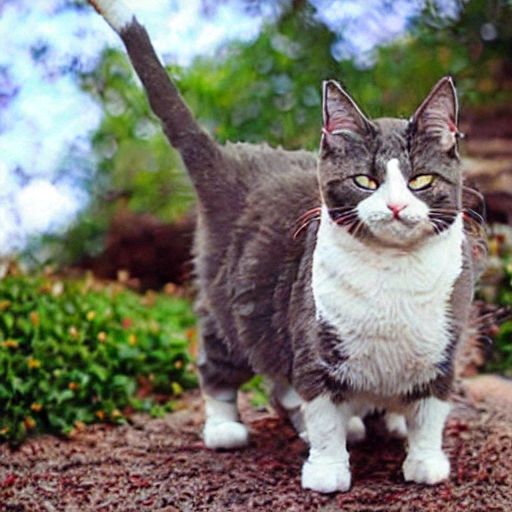

In [12]:
ort_outputs = sessDecoder.run(None, {
    'latent_sample': latents
    })[0]
img = numpy_to_pil(ort_outputs[0])
img[0].show()